<a href="https://colab.research.google.com/github/chphuttipan/mu-fip-analysis/blob/main/fip_analysis_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np

In [9]:
# Import the dataframe from google drive
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/fip_analysis/2025_fip_12wk.xlsx')

In [10]:
df.head(5)

,case_number,HN,name,age_y,breed,sex,bw0,Rivalta's test,RT-PCR,RT-PCR_sam,...,ind_bili24,ind_bili28,ind_bili32,ind_bili34,ind_bili36,ind_bili40,ind_bili42,ind_bili44,ind_bili48,ind_bili52
0,24,MU-25081-02,ธันวา,0.500000,Persain,Male (intact),1.9,positive,positive,body_fluid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,32,MU-3141-02,พี่ใหญ่,6.333333,American shorthair,Male (castrated),4.8,positive,positive,body_fluid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,37,MU-26128-03,บราวนี่,1.333333,DSH,Male (intact),3.2,positive,positive,body_fluid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,43,MU-26318-01,หลงหลง,10.250000,DSH,Male (intact),4.2,positive,positive,body_fluid,...,0.07,0.1,NaN,NaN,NaN,0.27,NaN,NaN,NaN,0.26
4,45,MU-26333-01,จูล่ง,2.750000,DSH,Male (intact),3.5,positive,positive,body_fluid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Drop a column 'name'
df.drop('name', axis=1, inplace=True)

In [12]:
# Turn the column names to lowercase
df.columns = df.columns.str.lower()

In [13]:
import re

# Rename a column name
df = df.rename(columns = {"rivalta's test": "rivalta", "status": "tx_status"})
df.columns = df.columns.str.replace(r'^eso', 'eos', regex=True)
df.columns = [
    col if not re.match(r'^cre\d+$', col) else col.replace('cre', 'crea', 1)
    for col in df.columns
]

In [14]:
# Adjust the wrong value in the 'plt12' from '72000 (clump)' to 72000
df['plt12'] = df['plt12'].replace('72000 (clump)', 72000)
df['plt16'] = df['plt16'].replace('67000 (clump)', 67000)
df['lymph16'] = df['lymph16'].replace(222.3, 2432.3)

<ipython-input-14-2796619024>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['plt12'] = df['plt12'].replace('72000 (clump)', 72000)
<ipython-input-14-2796619024>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['plt16'] = df['plt16'].replace('67000 (clump)', 67000)


In [15]:
# Copy the dataframe before wrangling and cleaning
df_copy = df.copy()

In [16]:
# Split the value in the column clin_sign to different columns
# Turn the value in the column to lowercase
df_copy['clin_sign'] = df_copy['clin_sign'].str.lower()
df_copy['clin_sign'] = df_copy['clin_sign'].replace(
    {'abdominal distension': 'abdominal_distension',
     'weight loss':'weight_loss'})

In [17]:
# Get all unique clinical signs
all_signs = sorted({sign for signs in df_copy['clin_sign']
                    for sign in signs.split(', ')})

print(all_signs)

['abdominal distension', 'abdominal_distension', 'anorexia', 'depress', 'dyspena', 'dyspnea', 'fever', 'pregnancy', 'weight loss']


In [18]:
# Create binary columns
for sign in all_signs:
    df_copy[sign] = df_copy['clin_sign'].apply(
        lambda x: 1 if sign in x.split(', ') else 0)

In [19]:
# Combine values, ensuring binary output
df_copy['dyspnea'] = (df_copy['dyspnea'] + df_copy['dyspena']).clip(upper=1)
df_copy['abdominal_distension'] = (df_copy['abdominal_distension'] +
                                   df_copy['abdominal distension']).clip(upper=1)

# Remove the misspelled column
df_copy = df_copy.drop(columns=['dyspena'])
df_copy = df_copy.drop(columns=['abdominal distension'])

In [20]:
# Rename a new column
df_copy.rename(columns={"weight loss": "weight_loss"}, inplace=True)

In [74]:
df_copy.loc[df_copy['hn'] == 'MU-31943-01', 'alb40'] = 2.2
df_copy.loc[df_copy['hn'] == 'MU-27806-01', 'plt40'] = 252000

In [75]:
# Create the columns 'nlr' as a neutrophil to lymphocyte ratio,
# 'plr' as a platelet to lymphocyte ratio
weeks = [0,1,3,7,12,16,20,24,28,32,36,40,44,48,52,60,64,72,78,84,96]
# bun/creatinine ratio column
for week in weeks:
  bun_col = f'bun{week}'
  crea_col = f'crea{week}'
  df_copy[f'bun_crea_ratio{week}'] = df_copy[bun_col] / df_copy[crea_col]
# neutrophil to lymphocyte ratio column
for week in weeks:
  neu_col = f'neu{week}'
  lymph_col = f'lymph{week}'
  nlr_col = f'nlr{week}'
  df_copy[nlr_col] = df_copy[neu_col] / df_copy[lymph_col]
# platelet to lymphocyte ratio column
for week in weeks:
  plt_col = f'plt{week}'
  lymph_col = f'lymph{week}'
  plr_col = f'plr{week}'
  df_copy[plr_col] = df_copy[plt_col] / df_copy[lymph_col]

Recheck value in the columns and correct it!

In [22]:
df_copy['breed'].value_counts()

,count
breed,
DSH,22
Scottish fold,7
British shorthair,5
Persain,3
American shorthair,2
Siamese,2
Munchkin,1


In [23]:
df_copy['sex'].unique()

array(['Male (intact)', 'Male (castrated)', 'Female (sprayed)',
       'Female (intact)'], dtype=object)

In [24]:
# Create a new column shows the intact status
df_copy['intact'] = df_copy['sex'].str.contains(r'\(intact\)').astype(int)

In [25]:
df_copy['sex'].value_counts()

,count
sex,
Male (intact),24
Female (intact),13
Male (castrated),3
Female (sprayed),2


In [26]:
df_copy['intact'].value_counts()

,count
intact,
1,37
0,5


Rearrange the columns position

In [27]:
# Move 'intact' column to the fifth column
intact_col = df_copy.pop('intact')
df_copy.insert(4, 'intact', intact_col)

In [28]:
# Turn the value of 'Male ...' and 'Female ...' to the plain 'male' and 'female'
df_copy.loc[df_copy['sex'].str.contains('Male'), 'sex'] = 'male'
df_copy.loc[df_copy['sex'].str.contains('Female'), 'sex'] = 'female'

In [29]:
df_copy['sex'].value_counts()

,count
sex,
male,27
female,15


### 2. cbc and biochemistry interpretation

In [30]:
# CBC profile interpretation
df_copy['leukocytosis'] = np.where(df_copy['wbc0'] > 19000, 1, 0)
df_copy['leukopenia'] = np.where(df_copy['wbc0'] < 5500, 1, 0)
df_copy['monocytosis'] = np.where(df_copy['mono0'] > 900, 1, 0)
df_copy['neutrophilia'] = np.where(df_copy['neu0'] > 14200, 1, 0)
df_copy['neutropenia'] = np.where(df_copy['neu0'] < 3000, 1, 0)
df_copy['lymphocytosis'] = np.where(df_copy['lymph0'] > 6800, 1, 0)
df_copy['lymphopenia'] = np.where(df_copy['lymph0'] < 1400, 1, 0)
df_copy['eosinophilia'] = np.where(df_copy['eos0'] > 700, 1, 0)
df_copy['basophilia'] = np.where(df_copy['baso0'] > 100, 1, 0)
df_copy['anemia'] = np.where(df_copy['hct0'] < 30, 1, 0)
df_copy['thrombocytopenia'] = np.where(df_copy['plt0'] < 100000, 1, 0)

In [31]:
# biochemistry profiles
df_copy['azotemia'] = np.where((df_copy['bun0'] > 36 )|
 (df_copy['crea0'] > 2.4), 1, 0)
df_copy['high_alt'] = np.where(df_copy['alt0'] > 130, 1, 0)
df_copy['high_alp'] = np.where(df_copy['alp0'] > 111, 1, 0)
df_copy['hypoalbuminemia'] = np.where(df_copy['alb0'] < 2.8, 1, 0)
df_copy['hypoproteinemia'] = np.where(df_copy['tp0'] < 5.7, 1, 0)
df_copy['hyperproteinemia'] = np.where(df_copy['tp0'] > 8.9, 1, 0)
df_copy['hyperglobulinemia'] = np.where(df_copy['glb0'] > 5.1, 1, 0)
df_copy['hyperbilirubinemia'] = np.where(df_copy['total_bili0'] > 0.5, 1, 0)

<ipython-input-31-1513039778>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy['hyperbilirubinemia'] = np.where(df_copy['total_bili0'] > 0.5, 1, 0)


In [32]:
df_copy.loc[:, 'leukocytosis':]

,leukocytosis,leukopenia,monocytosis,neutrophilia,neutropenia,lymphocytosis,lymphopenia,eosinophilia,basophilia,anemia,thrombocytopenia,azotemia,high_alt,high_alp,hypoalbuminemia,hypoproteinemia,hyperproteinemia,hyperglobulinemia,hyperbilirubinemia
0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0


In [33]:
df_copy.columns.tolist()

['case_number',
 'hn',
 'age_y',
 'breed',
 'intact',
 'sex',
 'bw0',
 'rivalta',
 'rt-pcr',
 'rt-pcr_sam',
 'lab_sample',
 'bact_culture',
 'fluid_analysis',
 'neoplasia',
 'tx_status',
 'max_week_fu',
 'clin_sign',
 'wbc0',
 'wbc1',
 'wbc3',
 'wbc7',
 'wbc12',
 'wbc14',
 'wbc16',
 'wbc20',
 'wbc24',
 'wbc28',
 'wbc32',
 'wbc34',
 'wbc36',
 'wbc40',
 'wbc42',
 'wbc44',
 'wbc48',
 'wbc52',
 'wbc60',
 'wbc64',
 'wbc72',
 'wbc78',
 'wbc84',
 'wbc96',
 'band0',
 'band1',
 'band3',
 'band7',
 'band12',
 'band14',
 'band16',
 'band20',
 'band24',
 'band28',
 'band32',
 'band34',
 'band36',
 'band40',
 'band 42',
 'band44',
 'band48',
 'band52',
 'band60',
 'band64',
 'band72',
 'band78',
 'band84',
 'band96',
 'neu0',
 'neu1',
 'neu3',
 'neu7',
 'neu12',
 'neu14',
 'neu16',
 'neu20',
 'neu24',
 'neu28',
 'neu32',
 'neu34',
 'neu36',
 'neu40',
 'neu42',
 'neu44',
 'neu48',
 'neu52',
 'neu60',
 'neu64',
 'neu72',
 'neu78',
 'neu84',
 'neu96',
 'mono0',
 'mono1',
 'mono3',
 'mono7',
 'mono12',

A new dataframe to analysis categorical data

In [34]:
# Create a categorical column list
cat_cols = ['breed', 'intact', 'sex', 'rivalta', 'rt-pcr', 'rt-pcr_sam',
            'lab_sample', 'bact_culture', 'fluid_analysis']

# Find the index of 'abdominal_distension' column
start_idx = df_copy.columns.get_loc('abdominal_distension')
stop_idx = df_copy.columns.get_loc('weight_loss')

# Get all columns from 'abdominal distension' to the end
cat_cols += list(df_copy.columns[start_idx:(stop_idx+1)])

start_idx = df_copy.columns.get_loc('leukocytosis')
stop_idx = df_copy.columns.get_loc('hyperbilirubinemia')
cat_cols += list(df_copy.columns[start_idx:(stop_idx+1)])

cat_df = df_copy.loc[:, cat_cols]

In [35]:
cat_df.columns

Index(['breed', 'intact', 'sex', 'rivalta', 'rt-pcr', 'rt-pcr_sam',
       'lab_sample', 'bact_culture', 'fluid_analysis', 'abdominal_distension',
       'anorexia', 'depress', 'dyspnea', 'fever', 'pregnancy', 'weight_loss',
       'leukocytosis', 'leukopenia', 'monocytosis', 'neutrophilia',
       'neutropenia', 'lymphocytosis', 'lymphopenia', 'eosinophilia',
       'basophilia', 'anemia', 'thrombocytopenia', 'azotemia', 'high_alt',
       'high_alp', 'hypoalbuminemia', 'hypoproteinemia', 'hyperproteinemia',
       'hyperglobulinemia', 'hyperbilirubinemia'],
      dtype='object')

In [36]:
# Find the value counts of each columns in the categorical dataframe
[cat_df[col].value_counts() for col in cat_df.columns]

[breed
 DSH                   22
 Scottish fold          7
 British shorthair      5
 Persain                3
 American shorthair     2
 Siamese                2
 Munchkin               1
 Name: count, dtype: int64,
 intact
 1    37
 0     5
 Name: count, dtype: int64,
 sex
 male      27
 female    15
 Name: count, dtype: int64,
 rivalta
 positive    34
 Name: count, dtype: int64,
 rt-pcr
 positive    28
 negative    11
 Name: count, dtype: int64,
 rt-pcr_sam
 body_fluid    42
 Name: count, dtype: int64,
 lab_sample
 pleural_effusion      22
 abdominal_effusion    20
 Name: count, dtype: int64,
 bact_culture
 no_growth    30
 Name: count, dtype: int64,
 fluid_analysis
 exudate                20
 modified_transudate    15
 Name: count, dtype: int64,
 abdominal_distension
 0    22
 1    20
 Name: count, dtype: int64,
 anorexia
 1    31
 0    11
 Name: count, dtype: int64,
 depress
 1    30
 0    12
 Name: count, dtype: int64,
 dyspnea
 1    22
 0    20
 Name: count, dtype: int64,
 fever

Find the median of the numerical columns

In [37]:
# Select column with numeric data types
numeric_columns = df_copy.select_dtypes(include=np.number).columns.tolist()

In [38]:
num_cols = numeric_columns.copy()

In [39]:
num_cols

['case_number',
 'age_y',
 'intact',
 'bw0',
 'neoplasia',
 'max_week_fu',
 'wbc0',
 'wbc1',
 'wbc3',
 'wbc7',
 'wbc12',
 'wbc14',
 'wbc16',
 'wbc20',
 'wbc24',
 'wbc28',
 'wbc32',
 'wbc34',
 'wbc36',
 'wbc40',
 'wbc42',
 'wbc44',
 'wbc48',
 'wbc52',
 'wbc60',
 'wbc64',
 'wbc72',
 'wbc78',
 'wbc84',
 'wbc96',
 'band0',
 'band1',
 'band3',
 'band7',
 'band12',
 'band14',
 'band16',
 'band20',
 'band24',
 'band28',
 'band32',
 'band34',
 'band36',
 'band40',
 'band 42',
 'band44',
 'band48',
 'band52',
 'band60',
 'band64',
 'band72',
 'band78',
 'band84',
 'band96',
 'neu0',
 'neu1',
 'neu3',
 'neu7',
 'neu12',
 'neu14',
 'neu16',
 'neu20',
 'neu24',
 'neu28',
 'neu32',
 'neu34',
 'neu36',
 'neu40',
 'neu42',
 'neu44',
 'neu48',
 'neu52',
 'neu60',
 'neu64',
 'neu72',
 'neu78',
 'neu84',
 'neu96',
 'mono0',
 'mono1',
 'mono3',
 'mono7',
 'mono12',
 'mono14',
 'mono16',
 'mono20',
 'mono24',
 'mono28',
 'mono32',
 'mono34',
 'mono36',
 'mono40',
 'mono42',
 'mono44',
 'mono48',
 'mono52'

In [40]:
# List the clinical problem columns
to_remove = ['case_number', 'intact', 'abdominal_distension', 'anorexia',
             'neoplasia', 'depress', 'dyspnea',
             'fever', 'pregnancy', 'weight_loss', 'leukocytosis',
             'leukopenia', 'monocytosis', 'neutrophilia', 'neutropenia',
             'lymphocytosis', 'lymphopenia', 'eosinophilia', 'basophilia',
             'anemia', 'thrombocytopenia', 'azotemia', 'high_alt',
             'high_alp', 'hypoalbuminemia', 'hypoproteinemia',
             'hyperproteinemia', 'hyperglobulinemia', 'hyperbilirubinemia']

# Remove the clinical problem columns
num_cols = [col for col in num_cols if col not in to_remove]

In [41]:
num_cols

['age_y',
 'bw0',
 'max_week_fu',
 'wbc0',
 'wbc1',
 'wbc3',
 'wbc7',
 'wbc12',
 'wbc14',
 'wbc16',
 'wbc20',
 'wbc24',
 'wbc28',
 'wbc32',
 'wbc34',
 'wbc36',
 'wbc40',
 'wbc42',
 'wbc44',
 'wbc48',
 'wbc52',
 'wbc60',
 'wbc64',
 'wbc72',
 'wbc78',
 'wbc84',
 'wbc96',
 'band0',
 'band1',
 'band3',
 'band7',
 'band12',
 'band14',
 'band16',
 'band20',
 'band24',
 'band28',
 'band32',
 'band34',
 'band36',
 'band40',
 'band 42',
 'band44',
 'band48',
 'band52',
 'band60',
 'band64',
 'band72',
 'band78',
 'band84',
 'band96',
 'neu0',
 'neu1',
 'neu3',
 'neu7',
 'neu12',
 'neu14',
 'neu16',
 'neu20',
 'neu24',
 'neu28',
 'neu32',
 'neu34',
 'neu36',
 'neu40',
 'neu42',
 'neu44',
 'neu48',
 'neu52',
 'neu60',
 'neu64',
 'neu72',
 'neu78',
 'neu84',
 'neu96',
 'mono0',
 'mono1',
 'mono3',
 'mono7',
 'mono12',
 'mono14',
 'mono16',
 'mono20',
 'mono24',
 'mono28',
 'mono32',
 'mono34',
 'mono36',
 'mono40',
 'mono42',
 'mono44',
 'mono48',
 'mono52',
 'mono60',
 'mono64',
 'mono72',
 'mono

In [42]:
median_cols = df_copy[num_cols].median()

In [43]:
# Check the normal distribution
from scipy.stats import shapiro

# Initialize results storage
results = []

# Perform Shapiro-Wilk test for each numeric columns
for col in num_cols:
  try:
    stat, p = shapiro(df_copy[col].dropna())
    results.append(
        {
          'Column': col,
          'Statistic': stat,
          'p-value': p,
          'Normal distribution': 'Yes' if p > 0.05 else 'No'
        }
    )
  except ValueError as e:
    results.append(
        {
          'Column': col,
          'Error': str(e)
        }
    )

# Convert results to DataFrame
results_df = pd.DataFrame(results)

<ipython-input-43-187126995>:10: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = shapiro(df_copy[col].dropna())
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [44]:
for index, row in results_df.iterrows():
  if row['Normal distribution'] == 'Yes':
    print(row)

Column                     wbc1
Statistic              0.980473
p-value                0.720729
Normal distribution         Yes
Name: 4, dtype: object
Column                    wbc12
Statistic              0.956607
p-value                0.147019
Normal distribution         Yes
Name: 7, dtype: object
Column                    wbc14
Statistic              0.921371
p-value                0.544661
Normal distribution         Yes
Name: 8, dtype: object
Column                    wbc24
Statistic              0.937711
p-value                0.468995
Normal distribution         Yes
Name: 11, dtype: object
Column                    wbc28
Statistic              0.970223
p-value                0.892908
Normal distribution         Yes
Name: 12, dtype: object
Column                    wbc32
Statistic              0.849453
p-value                0.238989
Normal distribution         Yes
Name: 13, dtype: object
Column                    wbc36
Statistic              0.890039
p-value                0.35

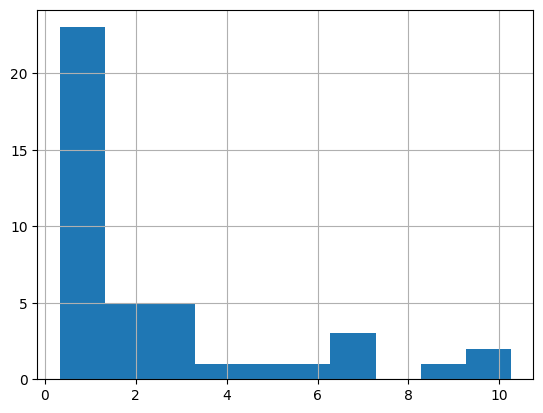

In [45]:
# Display the histogram
import matplotlib.pyplot as plt
df_copy['age_y'].hist()
plt.show()

Create a program to select specific parameter column and build a boxplot to display the value of each weeks

In [46]:
# List of parameters you want to plot
import re
from collections import Counter

# 1. List the numeric column first
numeric_cols = df_copy.select_dtypes(include='float').columns.tolist()

# 2. Extract the parameter prefix using regex
parameters = []
for col in numeric_cols:
  match = re.match(r'^(.+?)(\d+)$', col)
  if match:
    prefix = match.group(1) # group(1) is the parameter prefix (with underscore)
    parameters.append(prefix)

# 3. Find duplicated parameters (appearing more than once)
counts = Counter(parameters)
duplicated_params = {param for param, count in counts.items() if count > 1}

# 4. Filter columns belonging to duplicated parameters
cols_with_duplicated_params = [col for col in numeric_cols
                               if re.match(r'^(.+?)(\d+)$', col) and
                               re.match(r'^(.+?)(\d+)$', col).group(1) in
                               duplicated_params]

print("Duplicated parameters:", duplicated_params)
print("Columns with duplicated parameters:", cols_with_duplicated_params)

Duplicated parameters: {'glb', 'alp', 'ind_bili', 'hct', 'alb', 'ag_serum', 'lymph', 'baso', 'neu', 'eos', 'alt', 'nlr', 'total_bili', 'bun', 'crea', 'band', 'tp', 'plr', 'bun_crea_ratio', 'plt', 'mono', 'wbc', 'direct_bili'}
Columns with duplicated parameters: ['wbc0', 'wbc1', 'wbc3', 'wbc7', 'wbc12', 'wbc14', 'wbc16', 'wbc20', 'wbc24', 'wbc28', 'wbc32', 'wbc34', 'wbc36', 'wbc40', 'wbc42', 'wbc44', 'wbc48', 'wbc52', 'wbc60', 'wbc64', 'wbc72', 'wbc78', 'wbc84', 'wbc96', 'band0', 'band1', 'band3', 'band7', 'band12', 'band14', 'band16', 'band20', 'band24', 'band28', 'band32', 'band34', 'band36', 'band40', 'band44', 'band48', 'band52', 'band60', 'band64', 'band72', 'band78', 'band84', 'band96', 'neu0', 'neu1', 'neu3', 'neu7', 'neu12', 'neu14', 'neu16', 'neu20', 'neu24', 'neu28', 'neu32', 'neu34', 'neu36', 'neu40', 'neu42', 'neu44', 'neu48', 'neu52', 'neu60', 'neu64', 'neu72', 'neu78', 'neu84', 'neu96', 'mono0', 'mono1', 'mono3', 'mono7', 'mono12', 'mono14', 'mono16', 'mono20', 'mono24', '

In [47]:
def plot_parameter_boxplots(parameter_prefix, df, specific_weeks=None):
  """
  Parameters:
  - parameter_prefix: str, the prefix of the parameter
  (e.g., 'wbc', 'total_bili)
  - df: pandas DataFrame
  - specific_weeks: list of int (default: [0,1,3,5,7,12,16,20,24,28,32,36,40])
  """
  # Define default weeks if not provided
  if specific_weeks is None:
    specific_weeks = [0,1,3,5,7,12,16,20,24,28,32,36,40]

  # Select columns matching the parameter prefix and specific weeks
  selected_columns = []
  for col in df.columns:
    match = re.match(rf'^{parameter_prefix}(\d+)$', col)
    if match:
      week = int(match.group(1))
      if week in specific_weeks:
        selected_columns.append(col)

  if not selected_columns:
    print(f"No columns found with prefix '{parameter_prefix}'\
    with specified weeks.")
    return

  # Handle missing values: fill with median
  df_selected = df[selected_columns].apply(lambda x: x.fillna(x.median()))

  # Sort columns by week number
  df_selected = df_selected.reindex(
      sorted(selected_columns, key=lambda x:
             int(re.search(r'\d+$', x).group())),
      axis=1
  )

  # Create boxplot
  fig, ax = plt.subplots(figsize=(15, 6))
  bplot = ax.boxplot(df_selected, patch_artist=True, widths=0.3)

  # Set boxes, whiskers, cap, median to no fill and black edges
  for box in bplot['boxes']:
    box.set_facecolor('none')
    box.set_edgecolor('black')
    box.set_linewidth(1.5)
  for whisker in bplot['whiskers']:
    whisker.set(color='black', linewidth=1.5)
  for cap in bplot['caps']:
    cap.set(color='black', linewidth=1.5)
  for median in bplot['medians']:
    median.set(color='black', linewidth=1.5)

  plt.title(f'{parameter_prefix.upper()} Distribution by Week', fontsize=14)
  plt.xlabel('Week', fontsize=12)
  plt.ylabel(parameter_prefix.upper(), fontsize=12)

  # Set xticks to match the boxplot positions and labels
  weeks = [int(re.search(r'\d+$',col).group()) for col in df_selected.columns]
  ax.set_xticks(range(1, len(weeks) + 1))
  ax.set_xticklabels([f'Week {w}' for w in weeks],
                     rotation=45, fontsize=12)
  plt.show()

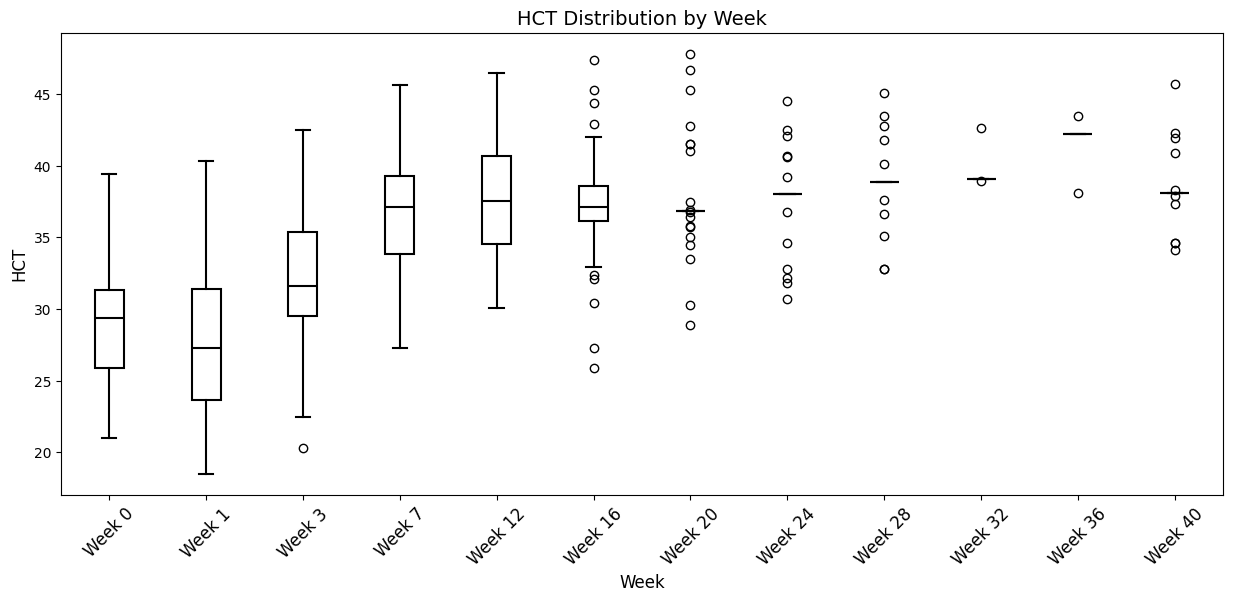

In [48]:
plot_parameter_boxplots('hct', df_copy)

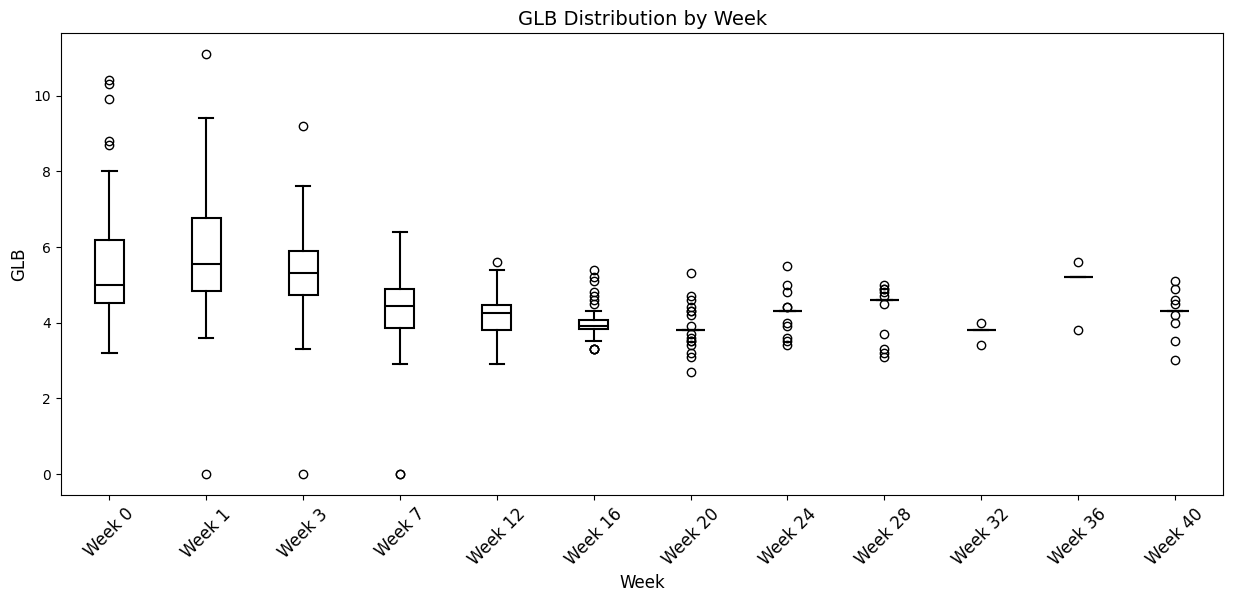

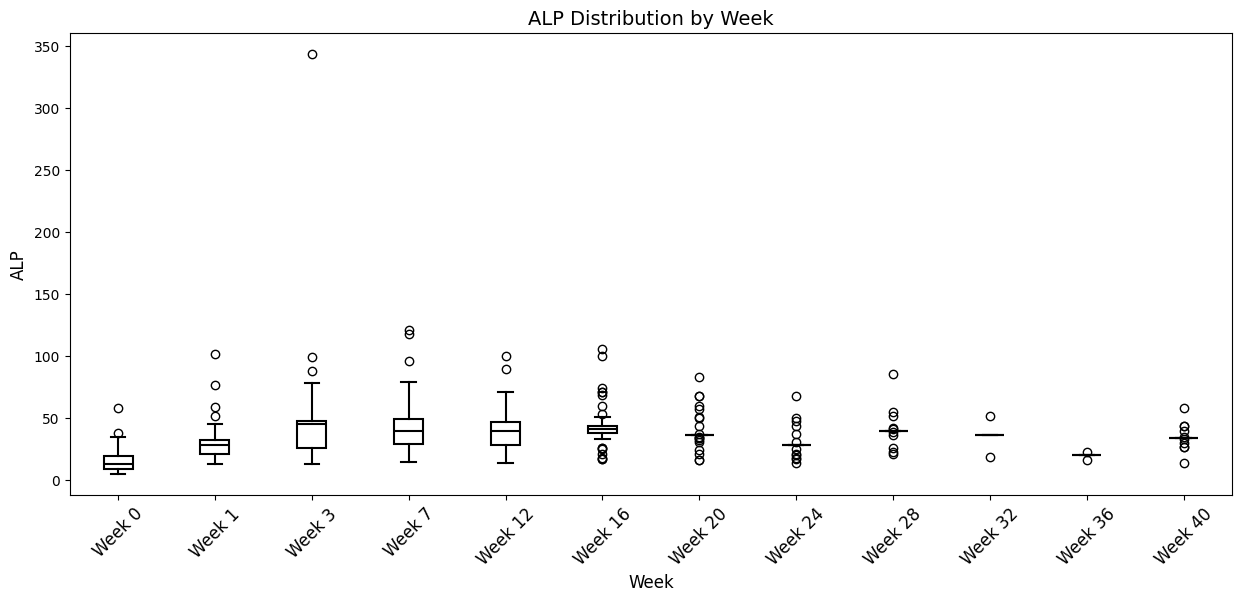

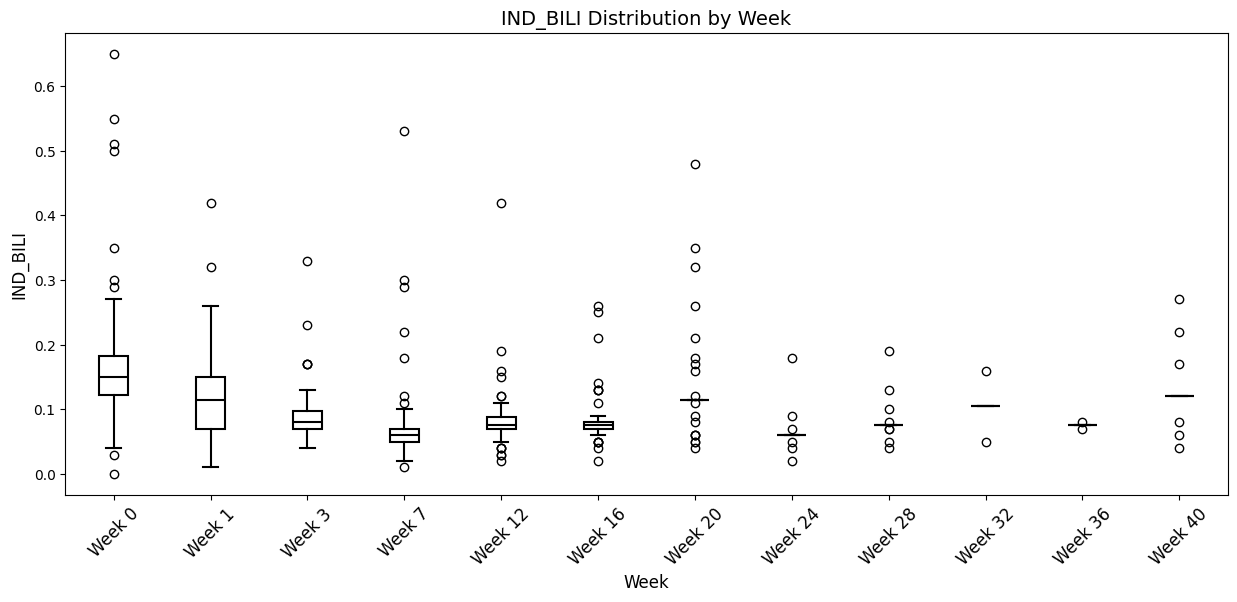

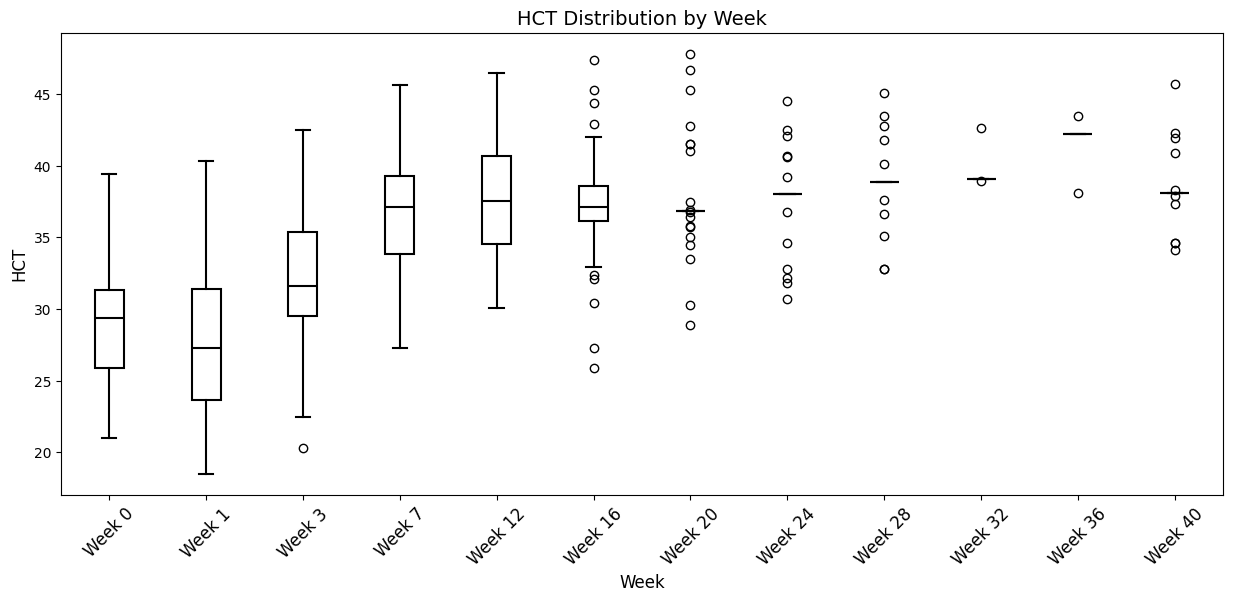

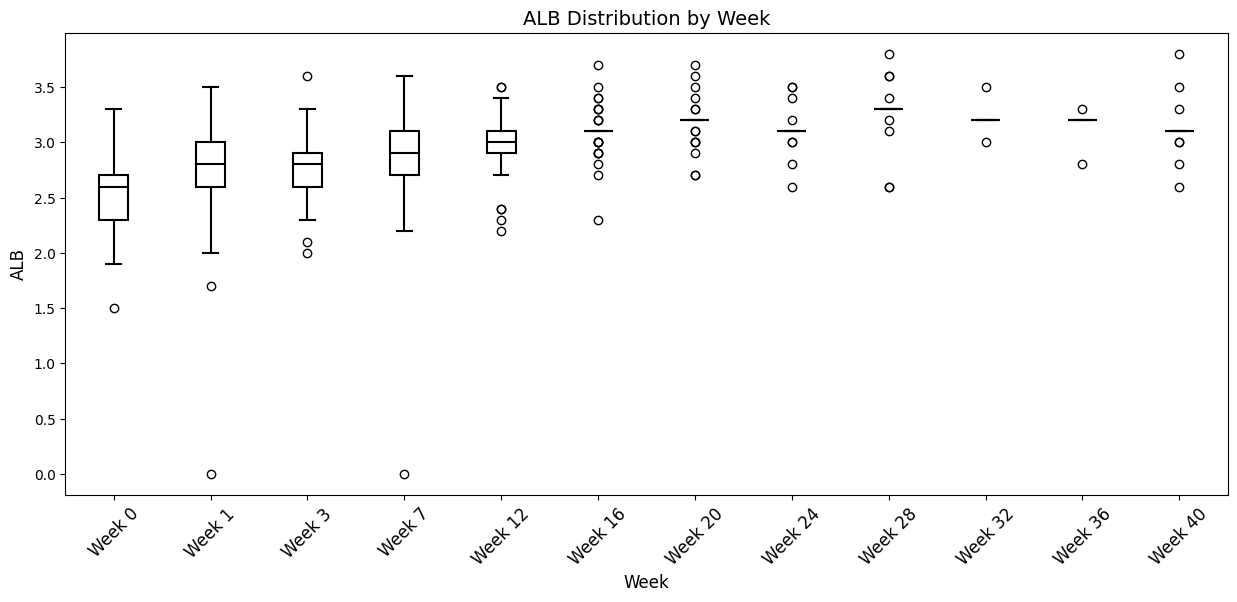

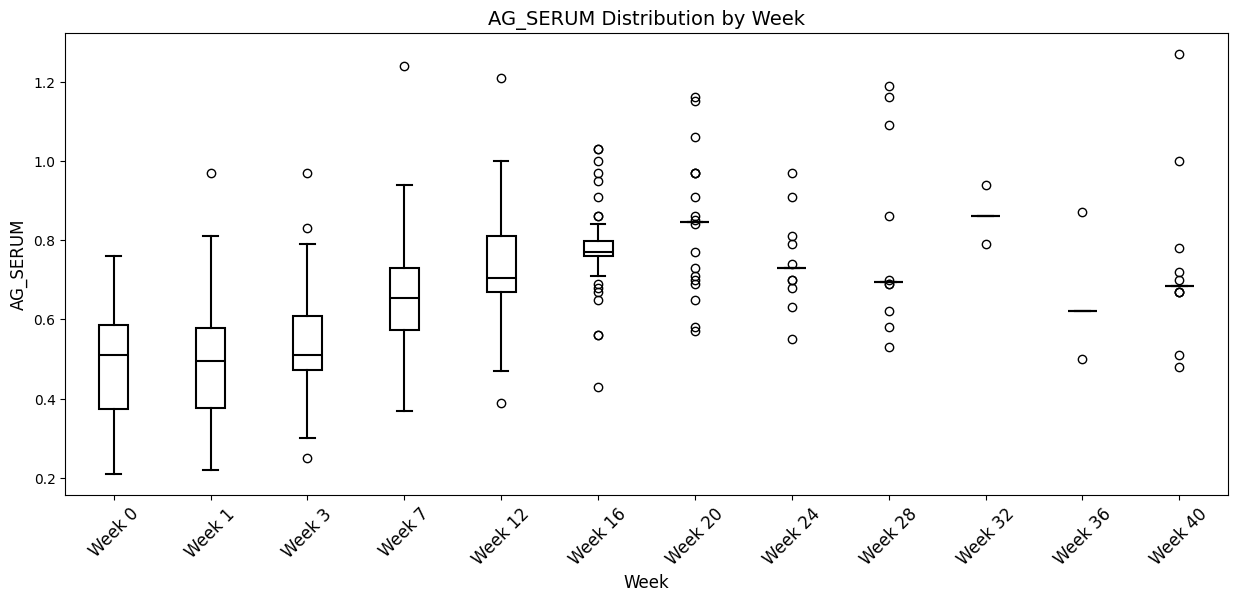

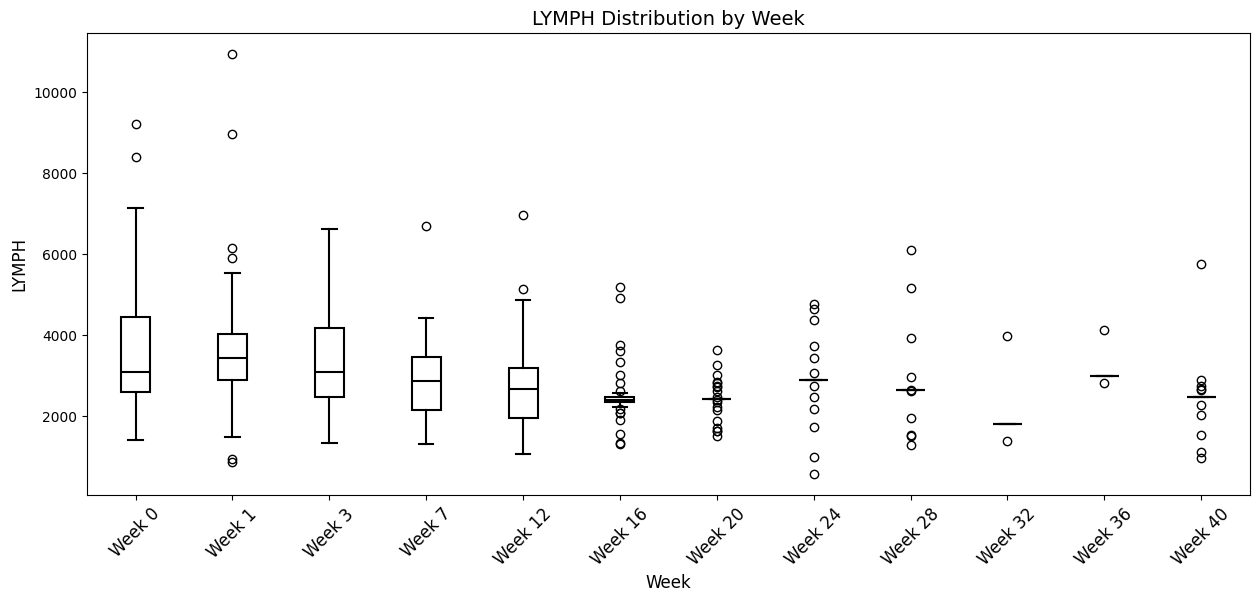

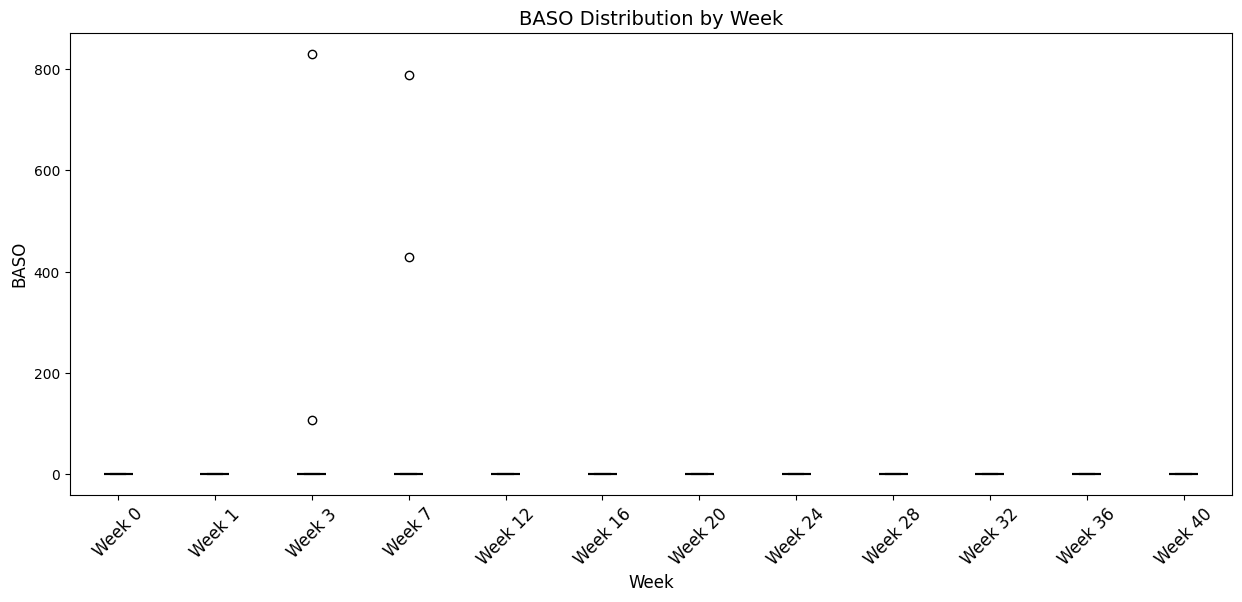

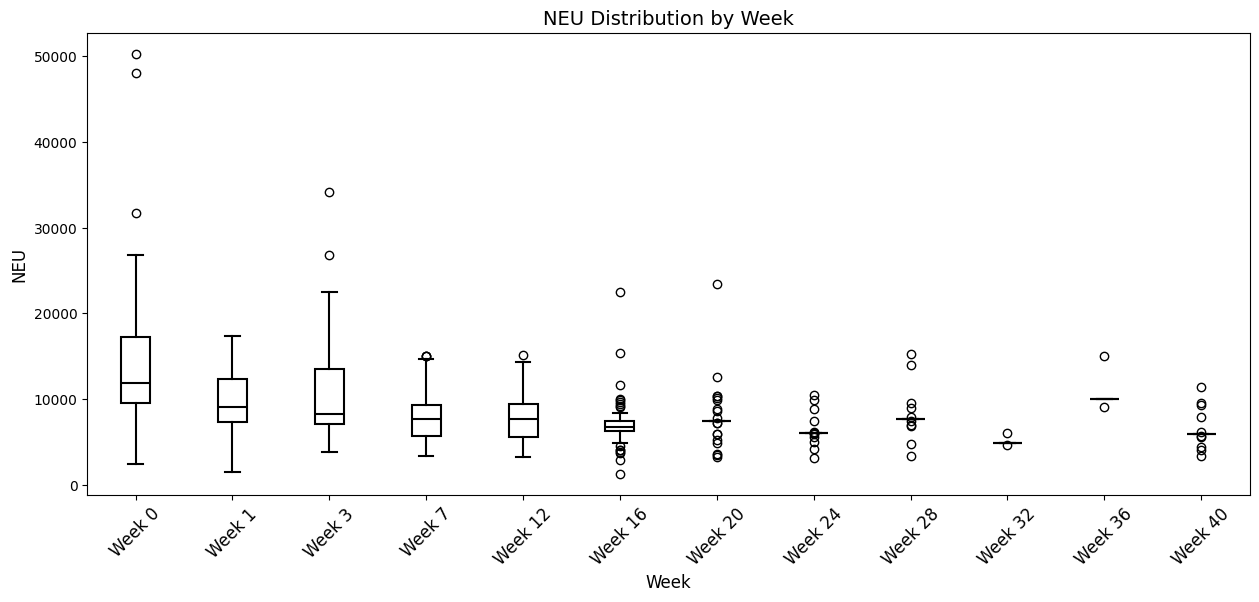

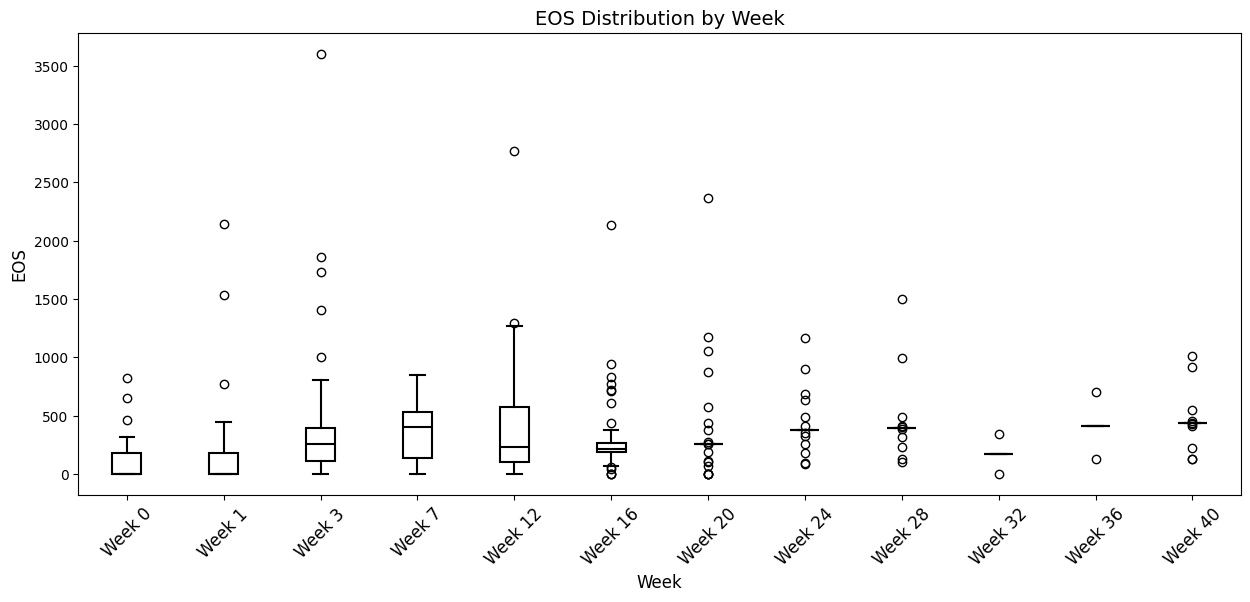

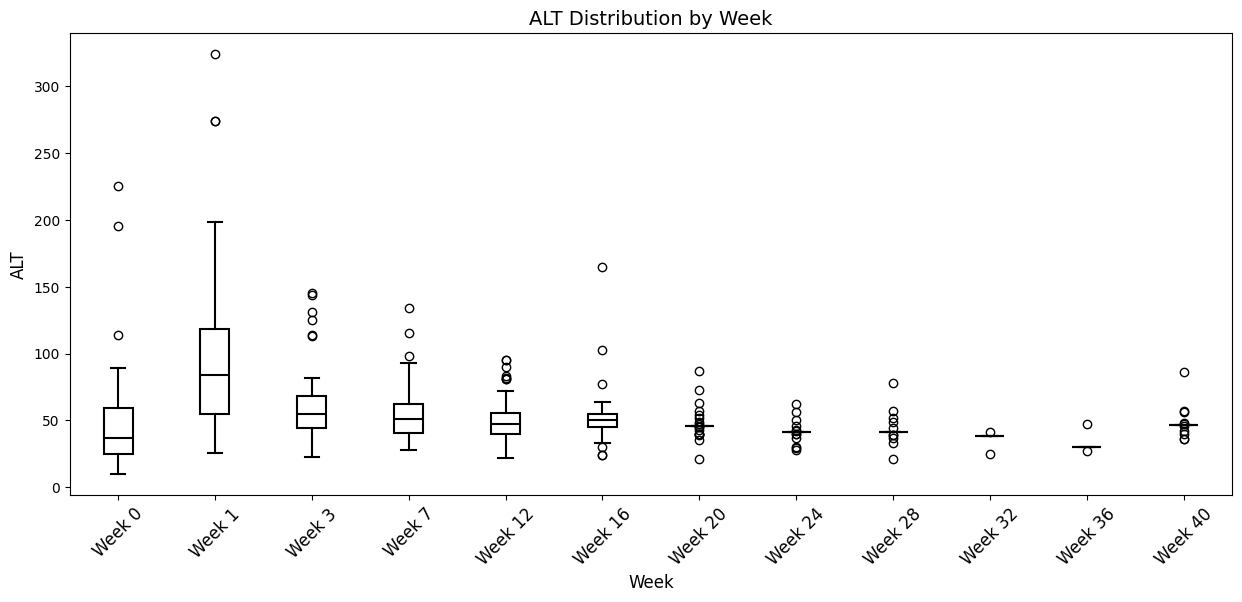

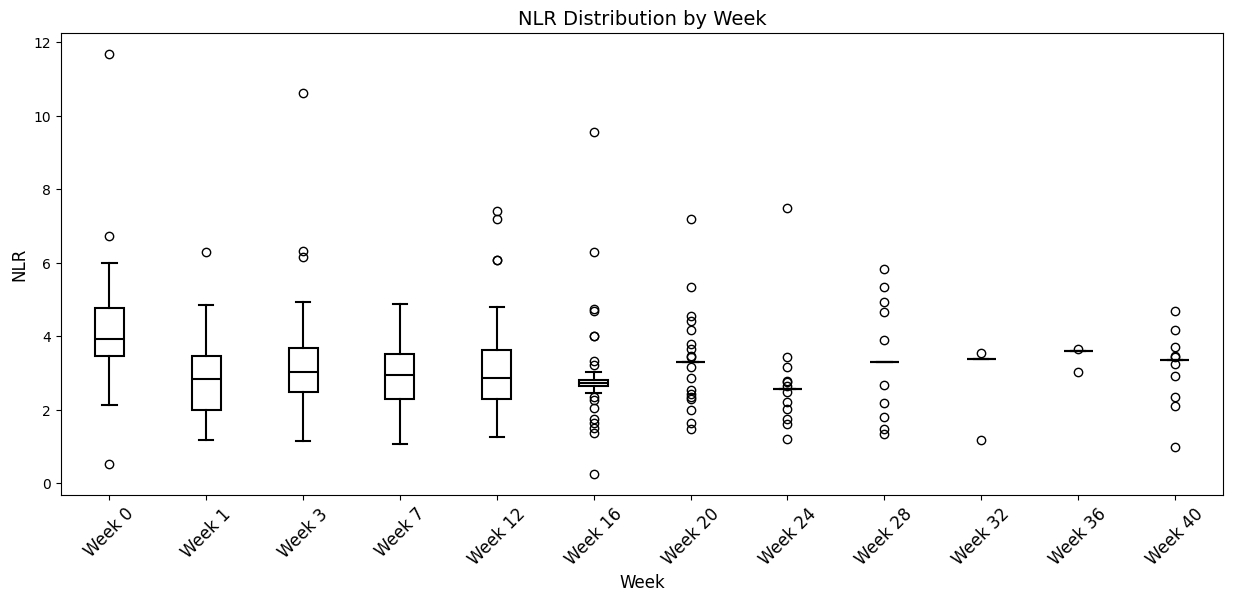

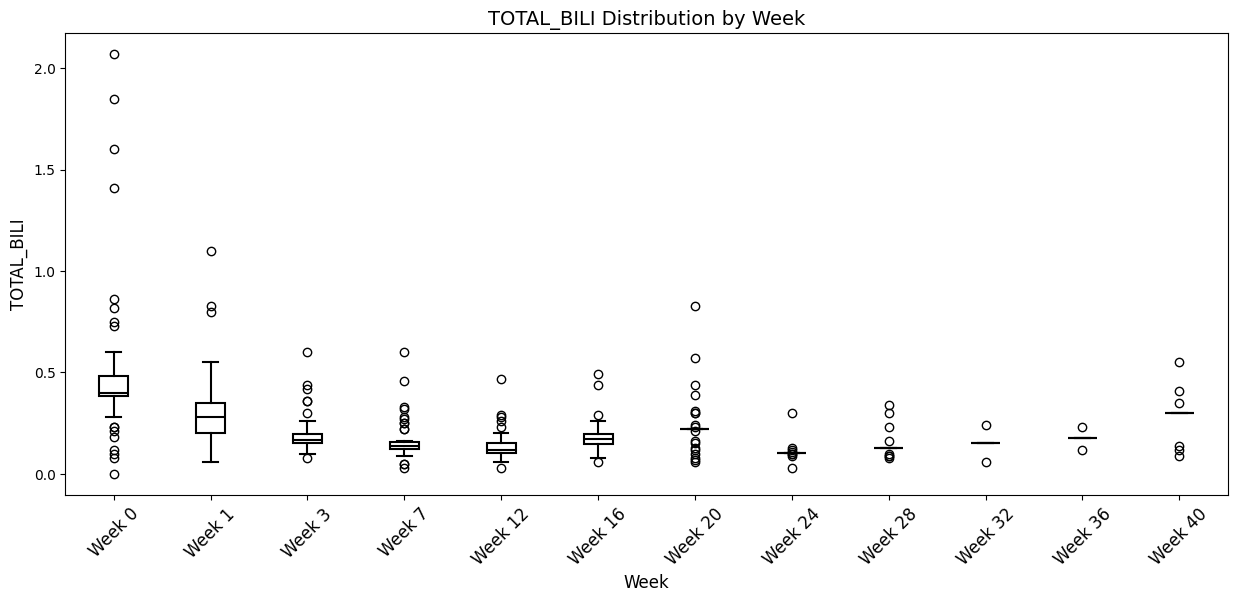

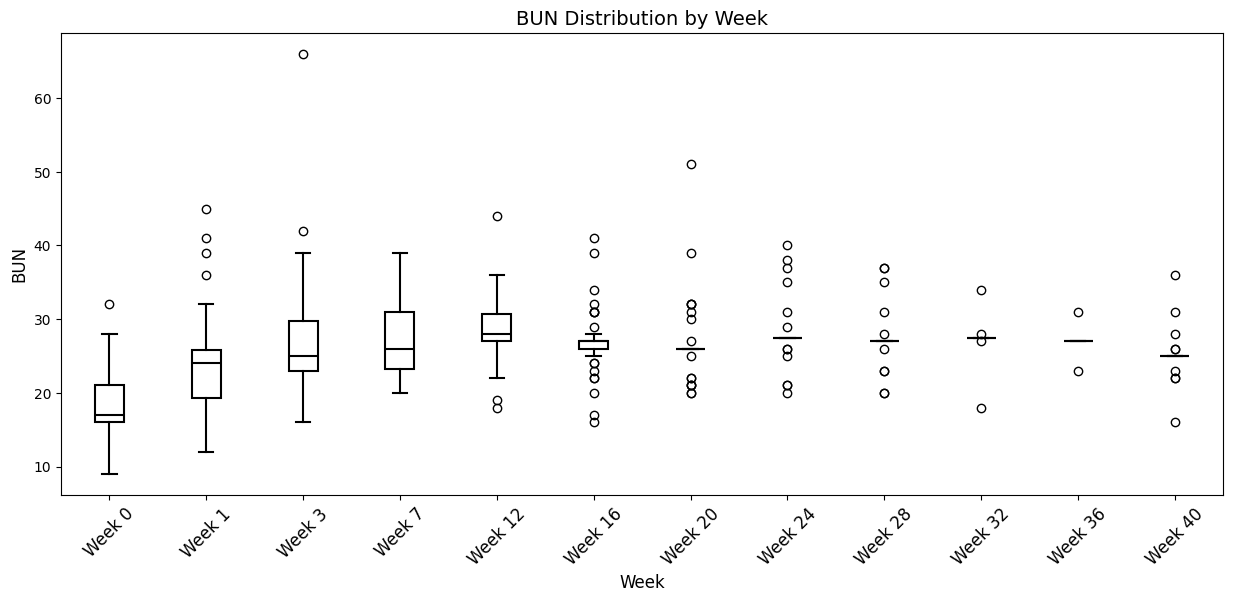

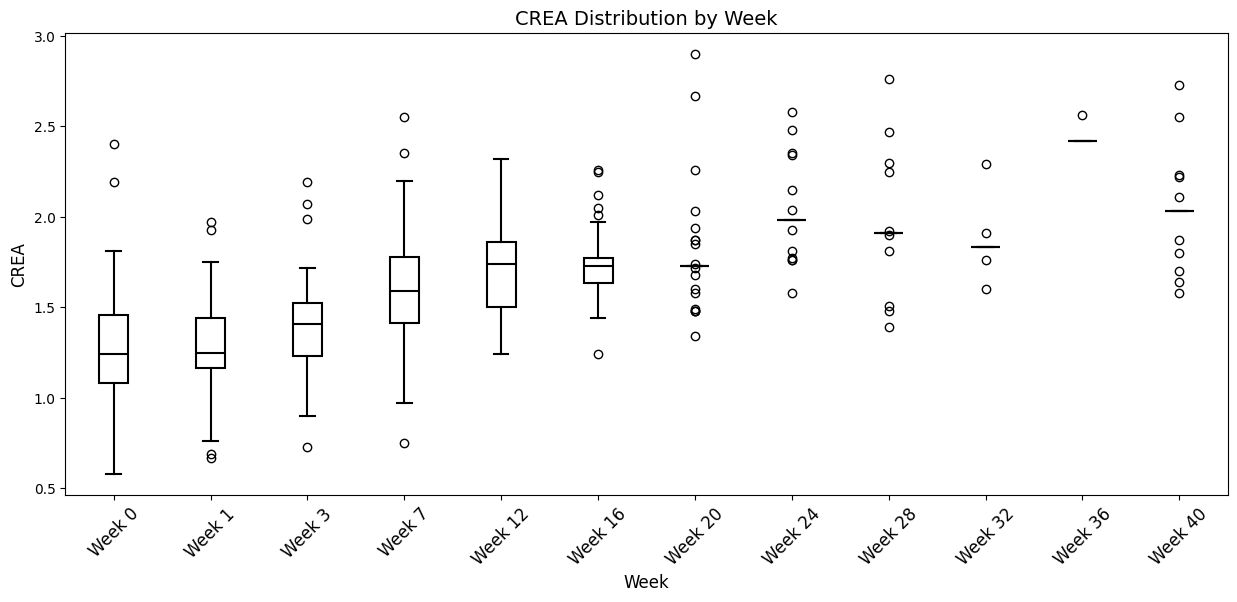

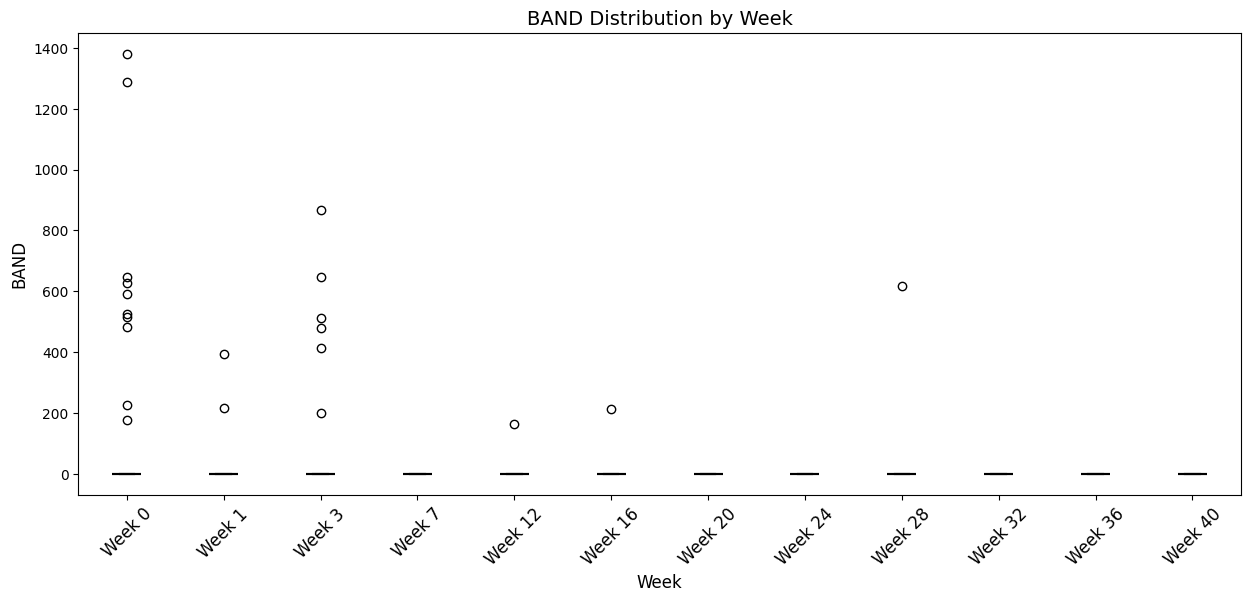

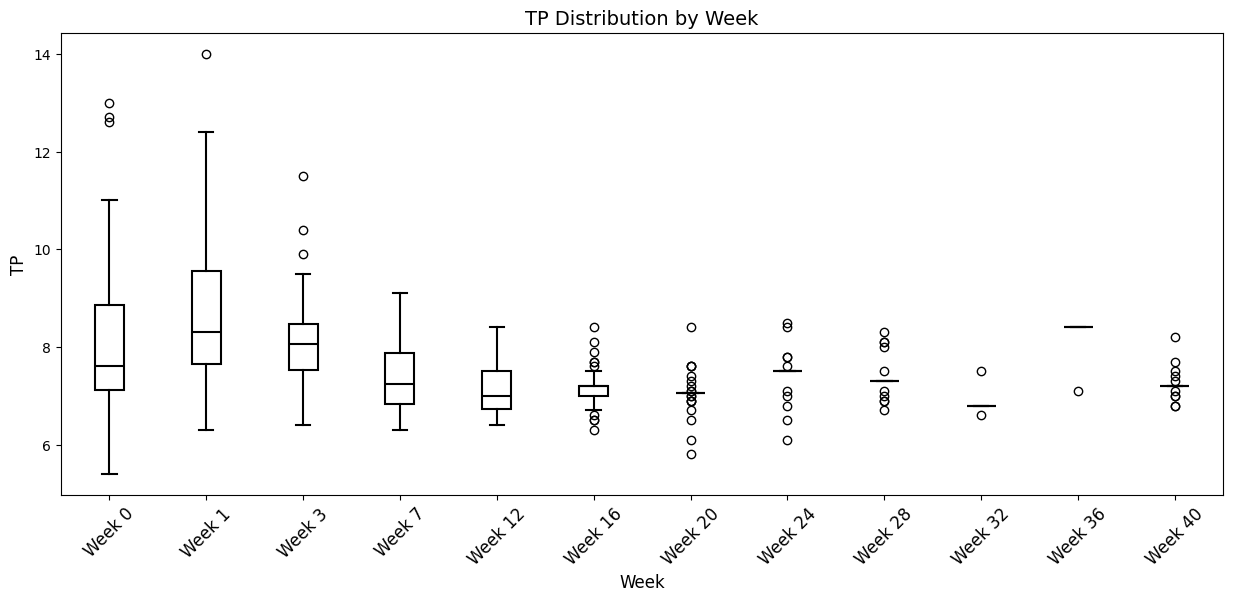

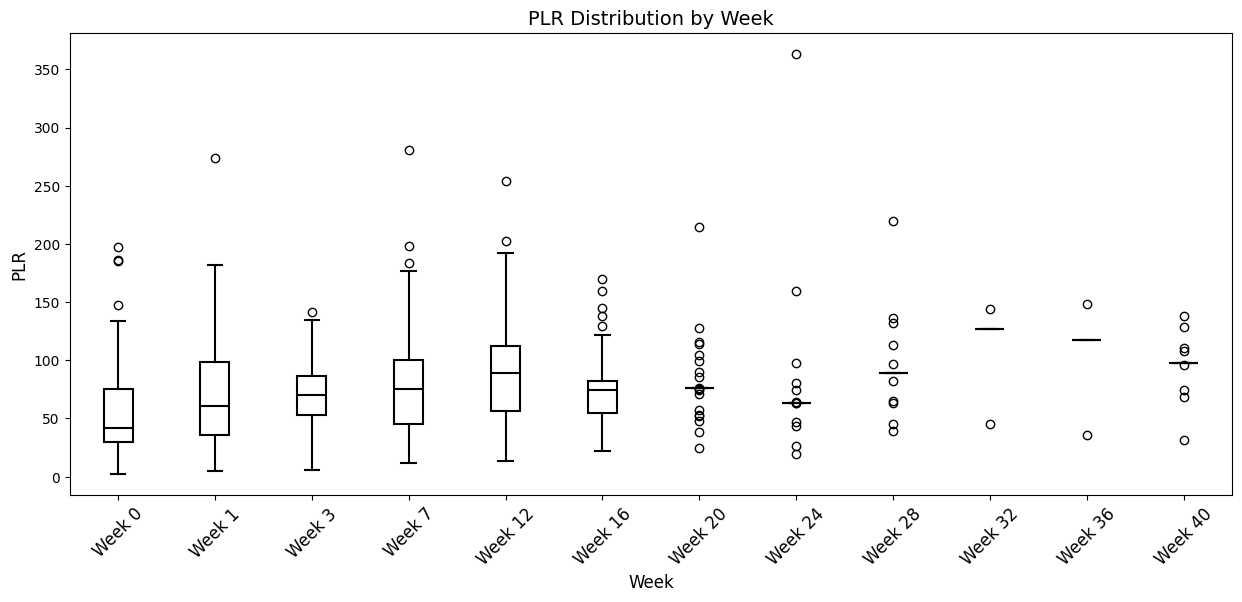

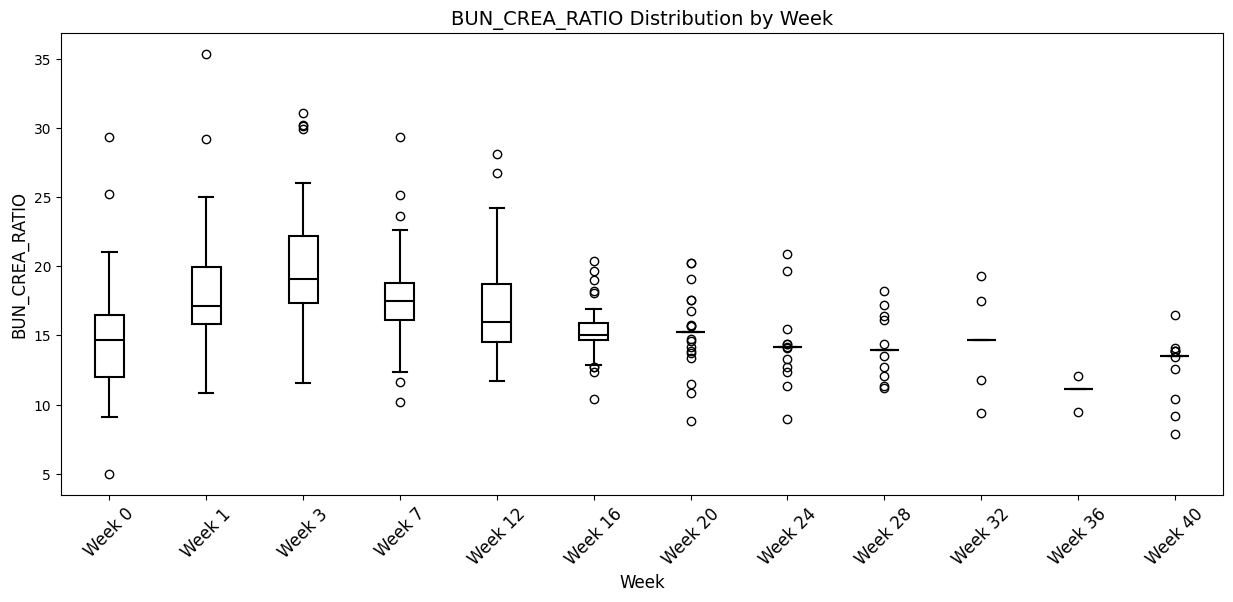

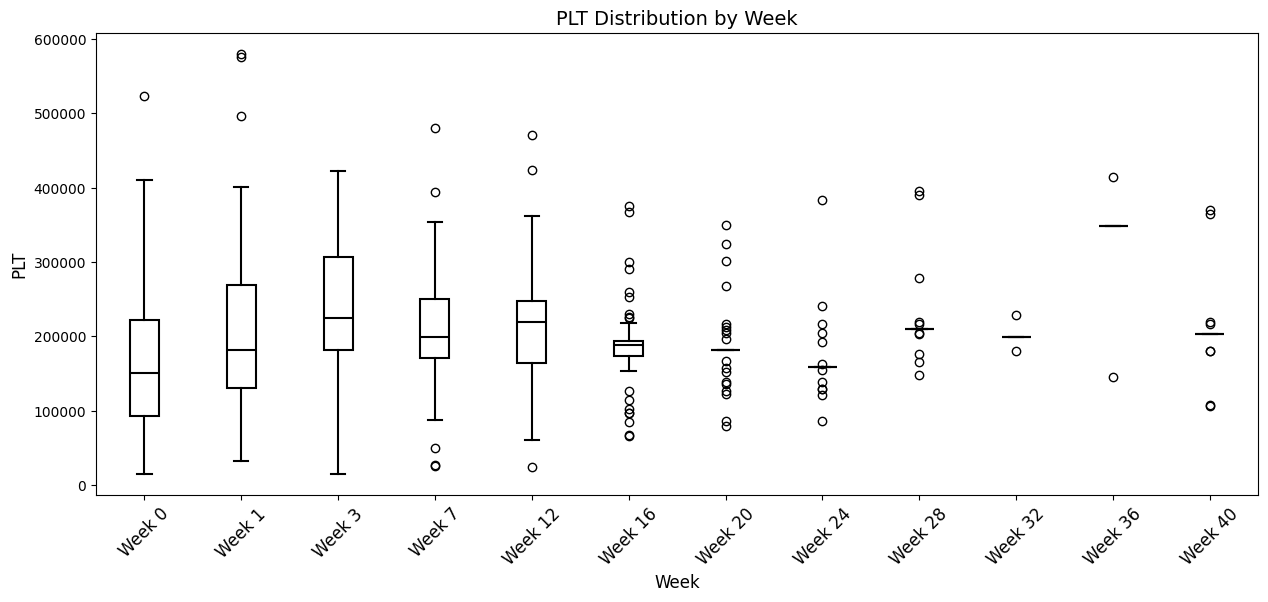

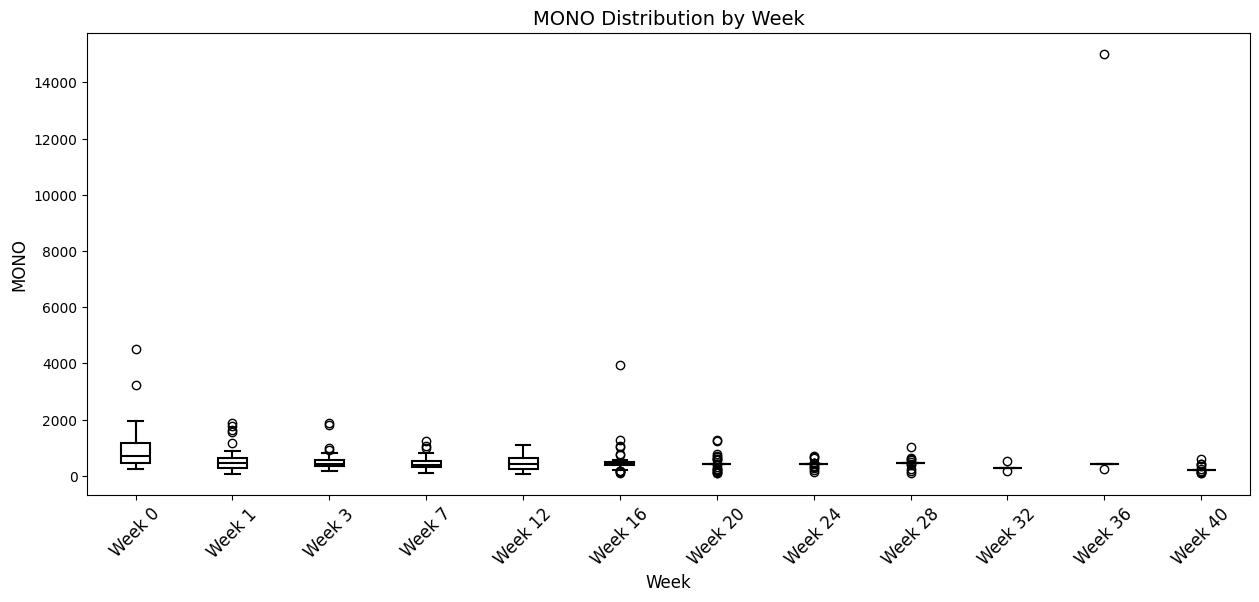

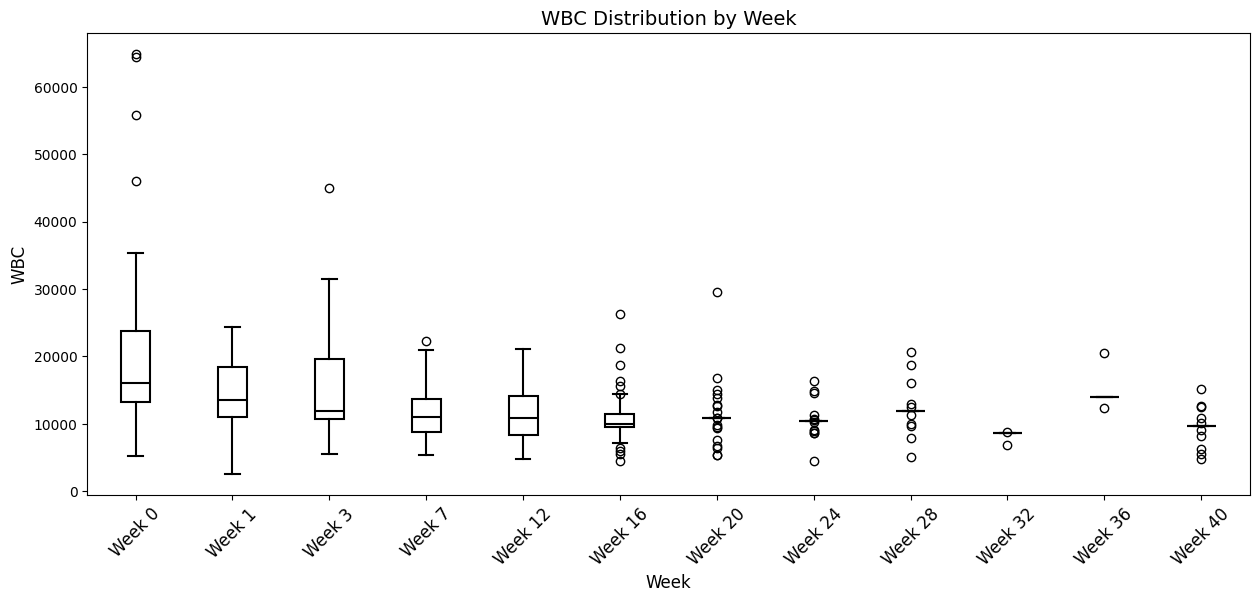

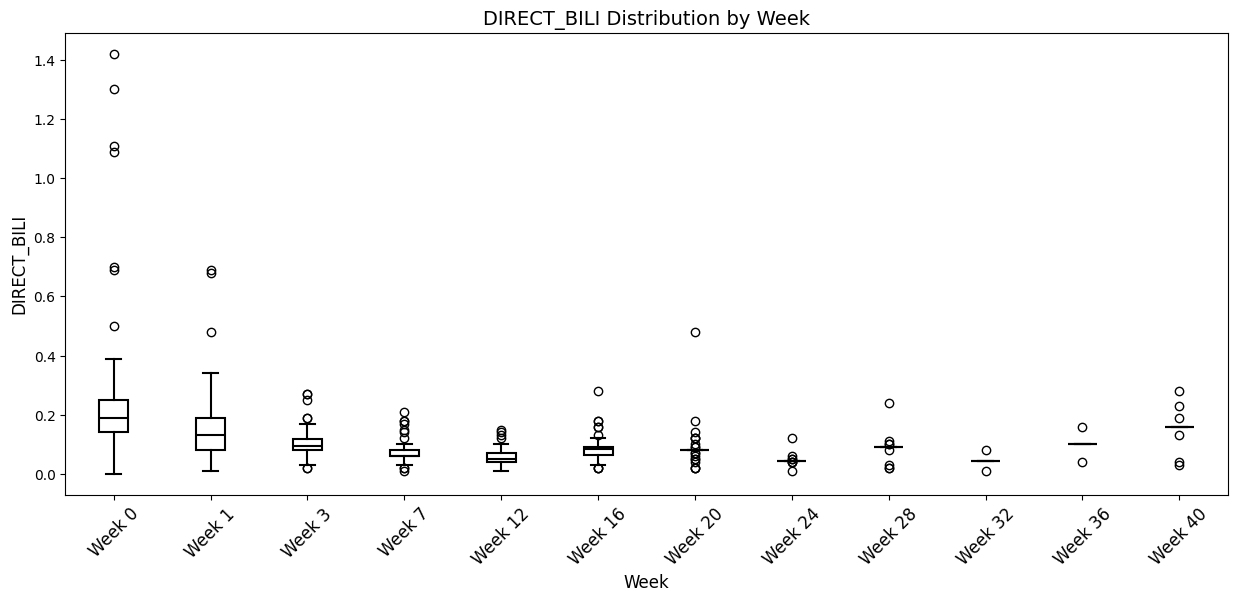

In [49]:
for param in duplicated_params:
  plot_parameter_boxplots(param, df_copy)

In [50]:
[param for param in cols_with_duplicated_params if param.startswith('cre')]

['crea0',
 'crea1',
 'crea3',
 'crea7',
 'crea12',
 'crea14',
 'crea16',
 'crea20',
 'crea24',
 'crea28',
 'crea32',
 'crea34',
 'crea36',
 'crea40',
 'crea42',
 'crea44',
 'crea48',
 'crea52',
 'crea60',
 'crea64',
 'crea72',
 'crea78',
 'crea84',
 'crea96']

In [51]:
df_copy['wbc40'].notnull().value_counts()

,count
wbc40,
False,32
True,10


Compare the two columns parameter value between week0 and other weeks

In [52]:
from scipy.stats import wilcoxon

def compare_col(prefix_param, df, specific_weeks=None):
  if specific_weeks is None:
    specific_weeks = [0,1,3,7,12,16,20,24,28,32,36,40]

  # 1. Filter and sort columns
  pattern = rf'^{prefix_param}({"|".join(map(str, specific_weeks))})$'
  param_cols = [col for col in df.columns if re.match(pattern, col)]

  if not param_cols:
    print(f"No columns found with prefix '{prefix_param}'\
    with specified weeks.")
    return

  # Sorted columns numerically by week
  param_cols = sorted(param_cols,
                      key=lambda x: int(re.search(r'\d+$', x).group()))

  results = {}
  for col in param_cols:
    if col != f'{prefix_param}0':
      # Drop rows with missing values in either column
      paired = df[[f'{prefix_param}0', col]].dropna()
      if not paired.empty:
        stat, p = wilcoxon(paired[f'{prefix_param}0'], paired[col])
        results[col] = {'statistic': stat, 'p-value': p}
      else:
        results[col] = {'statistic': None, 'p-value': None}



  for col, res in results.items():
    q25_0, q75_0 = np.nanpercentile(df[f'{prefix_param}0'], [25, 75])
    q25_col, q75_col = np.nanpercentile(df[col], [25, 75])
    q25_0 = round(q25_0, 2)
    q75_0 = round(q75_0, 2)
    q25_col = round(q25_col, 2)
    q75_col = round(q75_col, 2)

    print(f"Wilcoxon test between {prefix_param}0 and {col}:")
    print(f"Statistic: {res['statistic']}")
    print(f"p-value: {res['p-value']}")
    print(f"Median {prefix_param}0: {round(df[f'{prefix_param}0'].median(), 2)}\
    , [{q25_0} - {q75_0}]")
    print(f"Median {col}: {round(df[col].median(), 2)}, [{q25_col} - {q75_col}]\n")

Create program to perform Friedman test in the difference weeks and if the Friedman significant, it will show the result of post-hoc Wilcoxon signed rank test for each pair.

In [53]:
from scipy.stats import friedmanchisquare

def friedman_col(prefix_param, df, specific_weeks=None, alpha=0.05):
  if specific_weeks is None:
    specific_weeks = [0, 1, 7, 12]

  # Construct column names based on prefix and weeks
  columns = [f'{prefix_param}{week}' for week in specific_weeks]

  # Check if all columns exist in the dataframe
  missing_cols = [col for col in columns if col not in df.columns]
  if missing_cols:
    raise ValueError(f"Columns not found in DataFrame: {missing_cols}")

  # Extract data for the selected columns
  data = df[columns]

  # Drop rows with any missing values to ensure paired samples
  data_clean = data.dropna()

  if data_clean.shape[0] == 0:
    raise ValueError("No complete cases available after \
    dropping missing values.")

  # Prepare data for friedmanchisquare: each column as a separate array
  samples = [data_clean[col].values for col in columns]

  # Perform Friedman test
  friedman_stat, friedman_p = friedmanchisquare(*samples)

  print(f"Friedman test statistic: {friedman_stat:.4f}")
  print(f"P-value: {friedman_p:.4f}")

  results = {
      'friedman': {'statistic': friedman_stat, 'p_value': friedman_p},
      'wilcoxon': {}
  }

  # If Friedman test is significant, perform pairwise Wilcoxon signed-rank tests
  if friedman_p < alpha:
    print("\nFriedman test significant (p < {:.3f}), performing pairwise \
    Wilcoxon signed-rank tests:".format(alpha))
    pairs = []
    for i in range(len(columns)):
      for j in range(i + 1, len(columns)):
        pairs.append((columns[i], columns[j]))

    m = len(pairs) # number of comparisons for Bonferroni correction

    for col1, col2 in pairs:
      # Wilcoxon test on paired samples
      stat, p = wilcoxon(data_clean[col1], data_clean[col2])
      p_adj = p * m # Bonferroni correction
      p_adj = min(p_adj, 1.0) # p-value cannot exceed 1
      significant = p_adj < alpha

      print(f" {col1} vs {col2}: statistic={stat:.4f}, raw p_value={p:.4f}, \
      adjusted p={p_adj:.4f}, significant={significant}")

Create a novel Wilcoxon signed-rank test function

In [54]:
def friedman_plot(prefix_param, df, specific_weeks=None, alpha=0.05):
  friedman_col(prefix_param, df, specific_weeks, alpha)
  plot_parameter_boxplots(prefix_param, df, specific_weeks)

In [55]:
friedman_col('crea', df_copy, [0,1,7,12])

Friedman test statistic: 53.2014
P-value: 0.0000

Friedman test significant (p < 0.050), performing pairwise     Wilcoxon signed-rank tests:
 crea0 vs crea1: statistic=128.0000, raw p_value=0.0876,       adjusted p=0.5256, significant=False
 crea0 vs crea7: statistic=5.0000, raw p_value=0.0000,       adjusted p=0.0001, significant=True
 crea0 vs crea12: statistic=0.0000, raw p_value=0.0000,       adjusted p=0.0000, significant=True
 crea1 vs crea7: statistic=22.0000, raw p_value=0.0000,       adjusted p=0.0002, significant=True
 crea1 vs crea12: statistic=5.0000, raw p_value=0.0000,       adjusted p=0.0001, significant=True
 crea7 vs crea12: statistic=119.5000, raw p_value=0.0572,       adjusted p=0.3433, significant=False


In [56]:
def friedman_plot(prefix_param, df, specific_weeks=None, alpha=0.05):
  friedman_col(prefix_param, df, specific_weeks, alpha)
  plot_parameter_boxplots(prefix_param, df, specific_weeks)

In [57]:
num_cols

['age_y',
 'bw0',
 'max_week_fu',
 'wbc0',
 'wbc1',
 'wbc3',
 'wbc7',
 'wbc12',
 'wbc14',
 'wbc16',
 'wbc20',
 'wbc24',
 'wbc28',
 'wbc32',
 'wbc34',
 'wbc36',
 'wbc40',
 'wbc42',
 'wbc44',
 'wbc48',
 'wbc52',
 'wbc60',
 'wbc64',
 'wbc72',
 'wbc78',
 'wbc84',
 'wbc96',
 'band0',
 'band1',
 'band3',
 'band7',
 'band12',
 'band14',
 'band16',
 'band20',
 'band24',
 'band28',
 'band32',
 'band34',
 'band36',
 'band40',
 'band 42',
 'band44',
 'band48',
 'band52',
 'band60',
 'band64',
 'band72',
 'band78',
 'band84',
 'band96',
 'neu0',
 'neu1',
 'neu3',
 'neu7',
 'neu12',
 'neu14',
 'neu16',
 'neu20',
 'neu24',
 'neu28',
 'neu32',
 'neu34',
 'neu36',
 'neu40',
 'neu42',
 'neu44',
 'neu48',
 'neu52',
 'neu60',
 'neu64',
 'neu72',
 'neu78',
 'neu84',
 'neu96',
 'mono0',
 'mono1',
 'mono3',
 'mono7',
 'mono12',
 'mono14',
 'mono16',
 'mono20',
 'mono24',
 'mono28',
 'mono32',
 'mono34',
 'mono36',
 'mono40',
 'mono42',
 'mono44',
 'mono48',
 'mono52',
 'mono60',
 'mono64',
 'mono72',
 'mono

Friedman test statistic: 15.5806
P-value: 0.0014

Friedman test significant (p < 0.050), performing pairwise     Wilcoxon signed-rank tests:
 wbc0 vs wbc1: statistic=156.0000, raw p_value=0.0727,       adjusted p=0.4359, significant=False
 wbc0 vs wbc7: statistic=106.0000, raw p_value=0.0044,       adjusted p=0.0266, significant=True
 wbc0 vs wbc12: statistic=81.0000, raw p_value=0.0006,       adjusted p=0.0039, significant=True
 wbc1 vs wbc7: statistic=177.0000, raw p_value=0.1694,       adjusted p=1.0000, significant=False
 wbc1 vs wbc12: statistic=112.5000, raw p_value=0.0079,       adjusted p=0.0475, significant=True
 wbc7 vs wbc12: statistic=158.5000, raw p_value=0.0794,       adjusted p=0.4767, significant=False


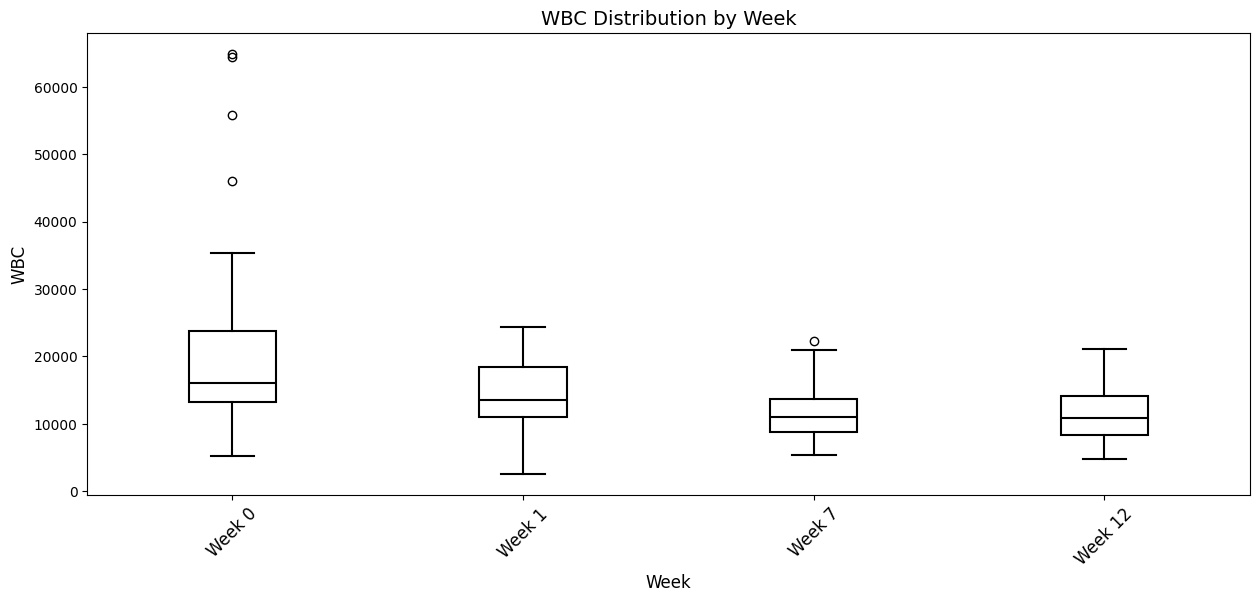

In [58]:
friedman_plot('wbc', df_copy, [0,1,7,12])

*เนื่องจากข้อมูลสัปดาห์ที่ 40 มีน้อยหากนำเข้ามาเทียบด้วย Friedman test และทำ post-hoc analysis ต่อจำนวน samples จะน้อยและค่าที่ได้จะมีผลต่อ p-value ให้แทนด้วยค่า median เพื่อเทียบกลุ่ม week40 อีกครั้ง

In [59]:
compare_col('wbc', df_copy, [0,1,7,12,40])

Wilcoxon test between wbc0 and wbc1:
Statistic: 184.0
p-value: 0.018340019683819264
Median wbc0: 16100.0    , [13130.0 - 24950.0]
Median wbc1: 13600.0, [10880.0 - 18675.0]

Wilcoxon test between wbc0 and wbc7:
Statistic: 113.0
p-value: 0.0005915096262469888
Median wbc0: 16100.0    , [13130.0 - 24950.0]
Median wbc7: 10950.0, [8607.5 - 14280.0]

Wilcoxon test between wbc0 and wbc12:
Statistic: 83.0
p-value: 5.452072946354747e-05
Median wbc0: 16100.0    , [13130.0 - 24950.0]
Median wbc12: 10915.0, [8375.0 - 15302.5]

Wilcoxon test between wbc0 and wbc40:
Statistic: 0.0
p-value: 0.00390625
Median wbc0: 16100.0    , [13130.0 - 24950.0]
Median wbc40: 9640.0, [6790.0 - 12067.5]



Combine two programs (boxplot graph and wilcoxon signed-rank test)

In [60]:
def bplot_wilcox(parameter_prefix, df, specific_weeks=None):
  plot_parameter_boxplots(parameter_prefix, df, specific_weeks)
  compare_col(parameter_prefix, df, specific_weeks)

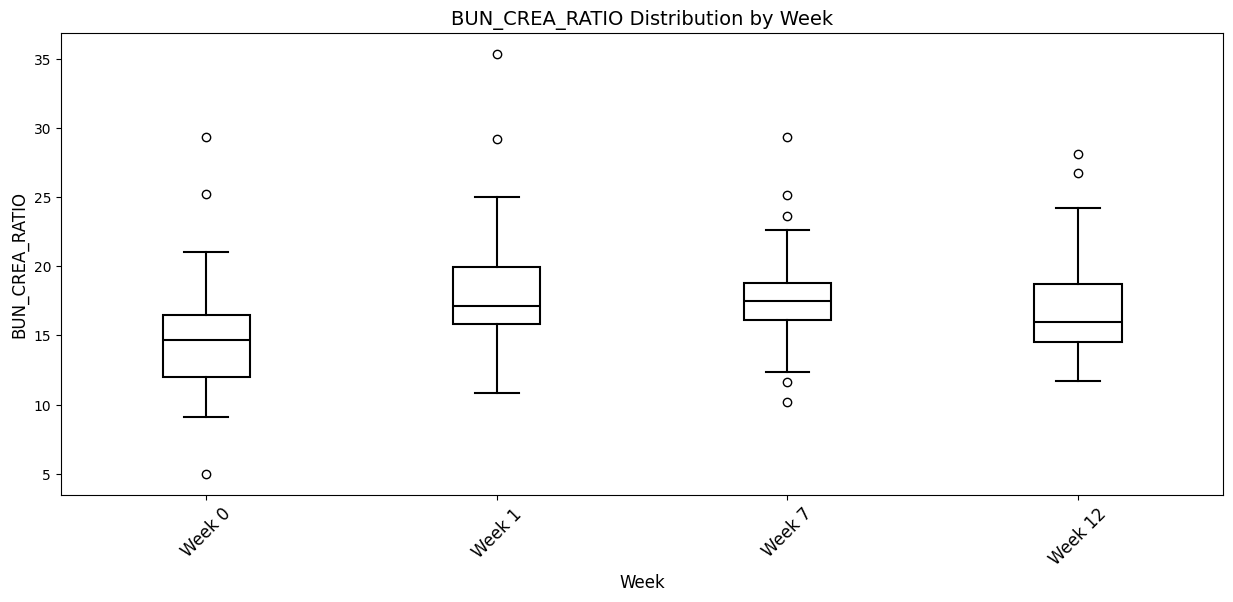

Wilcoxon test between bun_crea_ratio0 and bun_crea_ratio1:
Statistic: 65.0
p-value: 0.0005505755543708801
Median bun_crea_ratio0: 14.68    , [11.5 - 17.57]
Median bun_crea_ratio1: 17.16, [15.47 - 20.45]

Wilcoxon test between bun_crea_ratio0 and bun_crea_ratio7:
Statistic: 66.0
p-value: 0.00031275488436222076
Median bun_crea_ratio0: 14.68    , [11.5 - 17.57]
Median bun_crea_ratio7: 17.53, [15.95 - 19.21]

Wilcoxon test between bun_crea_ratio0 and bun_crea_ratio12:
Statistic: 121.0
p-value: 0.011704971082508564
Median bun_crea_ratio0: 14.68    , [11.5 - 17.57]
Median bun_crea_ratio12: 16.0, [14.52 - 19.2]



In [61]:
bplot_wilcox('bun_crea_ratio', df_copy, [0,1,7,12])

In [62]:
df_copy['hct40'].notnull().value_counts()

,count
hct40,
False,32
True,10


Export the dataframe as an excel sheet

In [63]:
df_copy.to_excel('/content/drive/MyDrive/Colab Notebooks/fip_analysis/20250506_fip_info.xlsx', index=False)

### Create a new dataframe replaced the missing values with the median of each columns

In [64]:
df_no_na = df_copy.copy()

Select the numerical columns for analyzing the data

In [65]:
num_cols = num_cols[3:]

Replace the missing value of id 'MU-31943-01' column 'alb40' by 2.2

In [73]:
df_copy.loc[df_copy['hn'] == 'MU-31943-01', 'alb40'] = 2.2
df_copy.loc[df_copy['hn'] == 'MU-27806-01', 'plt40'] = 252000

Replace the missing values with the median of each columns

In [67]:
for col in num_cols:
  df_no_na[col] = df_no_na[col].fillna(df_no_na[col].median())

In [77]:
def wilcox_col(prefix_param, df, df_clean, specific_weeks=None, alpha=0.05):
  if specific_weeks is None:
    specific_weeks = [0, 1, 7, 12]

  # Construct column names based on prefix and weeks
  columns = [f'{prefix_param}{week}' for week in specific_weeks]

  # Check if all columns exist in the dataframe
  missing_cols = [col for col in columns if col not in df.columns]
  if missing_cols:
    raise ValueError(f"Columns not found in DataFrame: {missing_cols}")

  # Extract data for the selected columns
  data = df[columns]

  # Display the number of samples in the column
  for col in columns:
    print(f"Number of samples in {col}: {df[col].notnull().sum()}")

  # Show the boxplot of each weeks
  plot_parameter_boxplots(prefix_param, df_clean, specific_weeks)

  pairs = []
  for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
      pairs.append((columns[i], columns[j]))

  # Wilcoxon test on paired samples
  for col1, col2 in pairs:
    stat, p = wilcoxon(df_clean[col1], df_clean[col2])
    print(f"{col1} vs {col2}: statistic={stat:.4f}, p-value={p:.4f}\n")
    col1_med = df_clean[col1].median()
    col2_med = df_clean[col2].median()
    q25_col1, q75_col1 = np.nanpercentile(df_clean[col1], [25, 75])
    q25_col2, q75_col2 = np.nanpercentile(df_clean[col2], [25, 75])
    print(f"Median {col1}: {col1_med}, IQR: [{q25_col1} - {q75_col1}]")
    print(f"Median {col2}: {col2_med}, IQR: [{q25_col2} - {q75_col2}]")


Number of samples in wbc12: 38
Number of samples in wbc40: 10


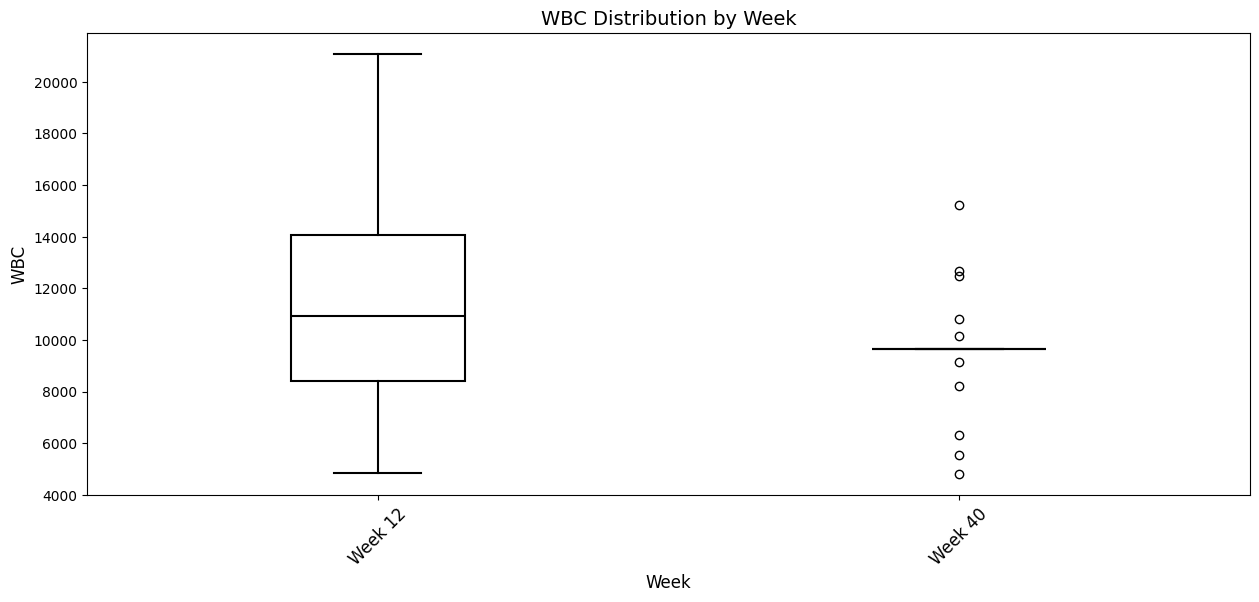

wbc12 vs wbc40: statistic=225.5000, p-value=0.0047

Median wbc12: 10915.0, IQR: [8405.0 - 14070.0]
Median wbc40: 9640.0, IQR: [9640.0 - 9640.0]


In [81]:
wilcox_col('wbc', df_copy, df_no_na, [12, 40])

In [72]:
df_copy[['hn', 'neu40', 'lymph40', 'plt40']]

,hn,neu40,lymph40,plt40
0,MU-25081-02,NaN,NaN,NaN
1,MU-3141-02,NaN,NaN,NaN
2,MU-26128-03,NaN,NaN,NaN
3,MU-26318-01,11415.0,2739.6,203000.0
4,MU-26333-01,NaN,NaN,NaN
5,MU-22467-01,NaN,NaN,NaN
6,MU-29545-01,NaN,NaN,NaN
7,MU-25329-01,NaN,NaN,NaN
8,MU-25676-01,NaN,NaN,NaN
9,MU-26595-01,NaN,NaN,NaN
